In [64]:
import datetime
import requests
import re
import matplotlib.pyplot as plt

## Core Idea

In developing projects, functionality is being added. As a rule, such functionality should be tested.

Hence the idea for the metric: we estimate the number of commits over the past year in which tests were
changed/added.

We are not considering all commits, but only those in which there were changes in the project source files (*.py files)

A commit is considered to be 'good' if it contains changes in test_\*.py files

There can be many commits per year, so no more than N commits are counted

Metrics output: |good_commits| / |N|

In [65]:
input_data = [
'https://github.com/PyCQA/pylint | 10',
'https://github.com/PyCQA/flake8 | 10',
'https://github.com/deepfakes/faceswap | 9',
'https://github.com/cookiecutter/cookiecutter | 8',
'https://github.com/zappa/zappa | 7',
'https://github.com/box/box-python-sdk | 7',
'https://github.com/box/flaky | 6',
'https://github.com/zalando/python-nsenter | 6',
'https://github.com/jazzband/django-pipeline | 5',
'https://github.com/tiangolo/full-stack | 4',
'https://github.com/miracle2k/flask-assets | 3',
'https://github.com/tiangolo/docker-auto-labels | 2',
'https://github.com/tiangolo/bitbucket_issues_to_redmine_csv | 1',
'https://github.com/zalando-stups/senza | 1',
'https://github.com/aizvorski/scikit-video | 1',
]

In [66]:
SECRET = ''
## ^ PUT YOUR SECRET KEY HERE ^

UNTIL = datetime.datetime(year=2020, month=11, day=1)
COMMITS_AMOUNT = 50

session = requests.Session()
assert SECRET
session.auth = ('DanielGabitov', SECRET)
test_function_pattern = re.compile(r'^(test_.*\.py|.*_test\.py)$')
source_file_pattern = re.compile(r'^.*py$')


def evaluate_commit(commit_data, owner, repo):
    url = f'https://api.github.com/repos/{owner}/{repo}/commits/{commit_data["sha"]}'
    fetched_data = session.get(url).json()
    file_names = [file['filename'].split('/')[-1] for file in fetched_data['files']]
    file_names = list(set(file_names))
    if all(not source_file_pattern.match(file_name) for file_name in file_names):
        return None
    if any(test_function_pattern.match(file_name) for file_name in file_names):
        return True
    return False


def get_score(owner, repo):
    good = 0
    total = 0
    page = 1
    commit_amount = 0
    commits = session.get(f"https://api.github.com/repos/{owner}/{repo}/commits?per_page=100&page={page}").json()
    flag = True
    while flag:
        for commit in commits:
            commit_amount += 1
            date: datetime = datetime.datetime.strptime(commit['commit']['committer']['date'], "%Y-%m-%dT%H:%M:%SZ")
            if date < UNTIL:
                flag = False
                break
            result = evaluate_commit(commit, owner, repo)
            if result is None:
                continue
            if result:
                good += 1
            total += 1
            if total >= COMMITS_AMOUNT:
                flag = False
        page += 1
        commits = session.get(f"https://api.github.com/repos/{owner}/{repo}/commits?per_page=100&page={page}").json()
        if len(commits) == 0:
            break
    if total == 0:
        return 0
    return good / total


def conduct_experiment(repos_data):
    results = []
    for line in repos_data:
        repo, my_score = line.replace(' ', '').split('|')
        x = repo.split('/')
        owner = x[-2]
        repo = x[-1]
        score = get_score(owner, repo)
        results.append((my_score, score))
    return results

In [67]:
exp_results = conduct_experiment(input_data)

In [68]:
def print_plot():
    y_labels_predicted = [int(x[0]) for x in exp_results]
    for i in range(0, len(data)):
        plt.plot(i, y_labels_predicted[i], 'go')

    y_labels_actual = [x[1] for x in exp_results]
    for i in range(0, len(data)):
        plt.plot(i, y_labels_actual[i] * 10, 'yo')
    plt.show()

## Results

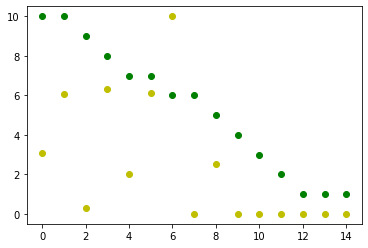

In [70]:
print_plot()

Yellow marks - the results of the metric, green marks - my rating for projects on a scale from 1 to 10.


Having tested the metric on the sample, we can conclude about the relationship between the 'alive' project and the result obtained.
I would use the metric in the following scenario: if the metric output > X (for instance 0.10), then the project is most likely supported and 'alive'.